In [2]:
# !nvidia-smi

In [3]:
# Обновление tensorflow
!pip install tensorflow --upgrade
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-yy5uuuyl
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-yy5uuuyl
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=2bdd74382435890b52b77193954e279f25d2cec9c08f895c45fdf97d1ebf3f60
  Stored in directory: /tmp/pip-ephem-wheel-cache-7k7p4764/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [4]:
# # Загрузка модели efficientnet
!pip install -q efficientnet

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
import zipfile
import csv
import sys
import os
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer
import efficientnet.keras as efn 

#from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification', 'sfcarclassif']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [6]:
# сохраняем версии пакетов
!pip freeze > requirements.txt

# Setup

In [7]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

RANDOM_SEED          = 42

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sfcarclassif/'
PATH = "../working/" # рабочая директория

# EDA

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


Нет пропусков.

In [10]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Данные распределены равномерно

In [11]:
train_df['Category'].nunique()

10

В датасете представлено 10 марок машин

Пример картинок


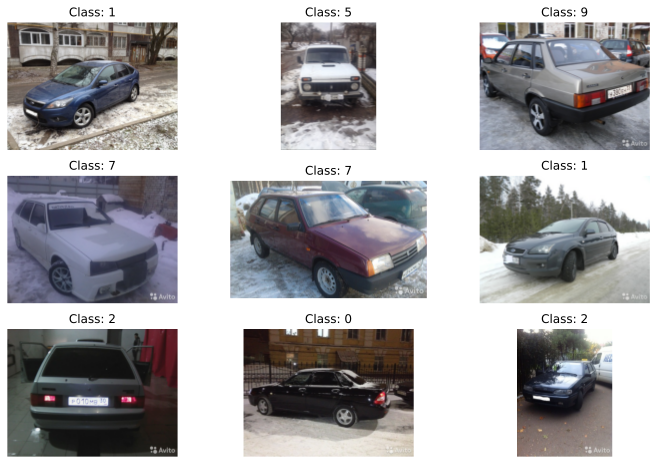

In [12]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+f'train/train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки представлены разного размера

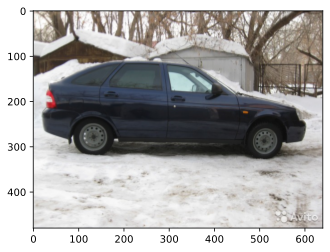

(640, 480)

In [13]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(DATA_PATH+f'train/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [14]:
#delete df no longer needed
del train_df
#collect residual garbage
gc.collect()

28

# Аугментация данных

In [15]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [16]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

# Генерация данных

In [17]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


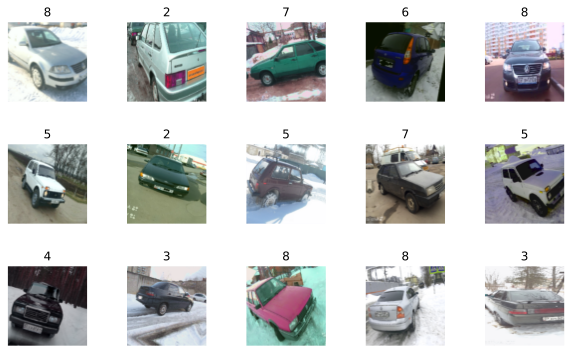

In [18]:
train_datagen.show_data(rows=3, cols=5)

# Transfer learning с Fine-tuning

## Этап 1. Замораживаем базовую часть модели полностью

Будем использовать предобученную модель EfficientNetB5

In [19]:
# # Загрузка модели efficientnet
# !pip install -q efficientnet

In [20]:
# Pre-trained model

#base_model = Xception(weights='imagenet', 
#                      include_top=False, 
#                      input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                         include_top=False, 
#                         input_shape = input_shape)

base_model = efn.EfficientNetB5(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

115515392/115515256 [==============================] - 5s 0us/step


In [21]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [22]:
# Используем предобученную модель без головы. Будем обучать свою
base_model.trainable = False

In [23]:
# Архитектура головы
model=Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 527,626
Non-trainable params: 28,514,032
______________________________________

In [25]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f9b5fbb4c50> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9b4359a8d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9b435f6510> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9b43408d50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9ad0585f50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9b43579890> True


## Обучение модели

In [26]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [27]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [28]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 332s 192ms/step - loss: 1.8796 - accuracy: 0.3783 - val_loss: 1.0410 - val_accuracy: 0.6473

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 187s 113ms/step - loss: 1.3957 - accuracy: 0.5039 - val_loss: 0.9944 - val_accuracy: 0.6482

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 190s 115ms/step - loss: 1.3110 - accuracy: 0.5302 - val_loss: 0.9211 - val_accuracy: 0.6778

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 186s 112ms/step - loss: 1.2572 - accuracy: 0.5568 - val_loss: 0.8988 - val_accuracy: 0.6890

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 187s 113ms/step - loss: 1.2206 - accuracy: 0.5758 - val_loss: 0.8802 - val_accuracy: 0.6980

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
1654/1654 [==============

In [29]:
#model.save('../working/model_last.hdf5') 
model.load_weights('best_model.hdf5')

In [30]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 28s 97ms/step - loss: 0.8507 - accuracy: 0.7119
Accuracy: 71.19%


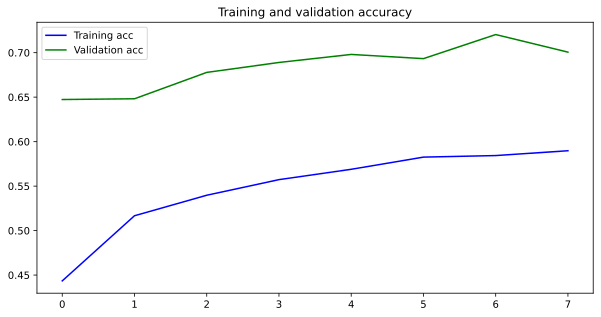

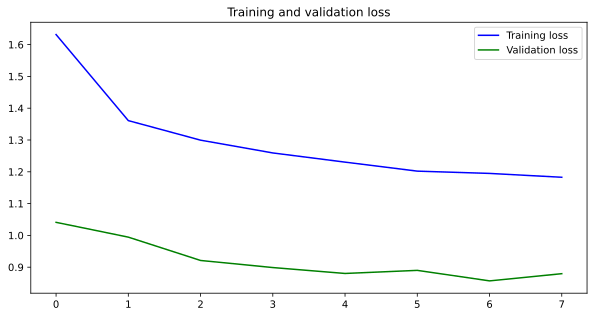

In [31]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Этап 2. Разморозка половины слоев базовой модели

In [32]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [33]:
LR=0.0001
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 26,777,098
Non-trainable params: 2,264,560
____________________________________

In [35]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 242s 136ms/step - loss: 1.3966 - accuracy: 0.5421 - val_loss: 0.4284 - val_accuracy: 0.8527

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 222s 134ms/step - loss: 0.6549 - accuracy: 0.7659 - val_loss: 0.3028 - val_accuracy: 0.8991

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 223s 135ms/step - loss: 0.4835 - accuracy: 0.8343 - val_loss: 0.2641 - val_accuracy: 0.9102

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 222s 134ms/step - loss: 0.3903 - accuracy: 0.8643 - val_loss: 0.2406 - val_accuracy: 0.9184

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 223s 135ms/step - loss: 0.3160 - accuracy: 0.8975 - val_loss: 0.2635 - val_accuracy: 0.9145

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
1654/1654 [==============

In [36]:
#model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5') 

In [37]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 28s 94ms/step - loss: 0.2141 - accuracy: 0.9343
Accuracy: 93.43%


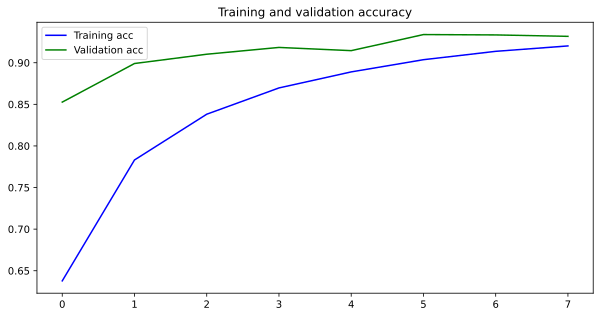

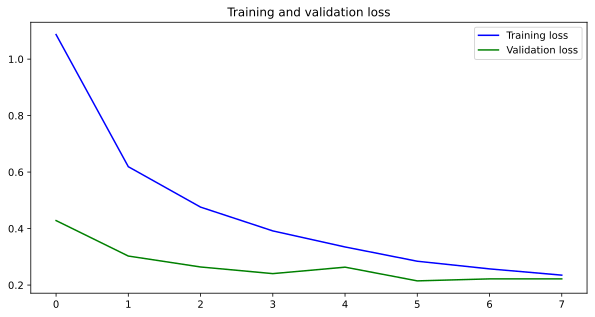

In [38]:
plot_history(history)

## Этап 3. Разморозка 75% слоев базовой модели

In [39]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [40]:
LR=0.00001

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,603,274
Non-trainable params: 438,384
______________________________________

In [42]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 259s 146ms/step - loss: 0.2231 - accuracy: 0.9265 - val_loss: 0.1826 - val_accuracy: 0.9424

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 240s 145ms/step - loss: 0.1847 - accuracy: 0.9380 - val_loss: 0.1924 - val_accuracy: 0.9416

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 240s 145ms/step - loss: 0.1642 - accuracy: 0.9468 - val_loss: 0.1893 - val_accuracy: 0.9416

Epoch 00003: saving model to best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 4/8
1654/1654 [==============================] - 241s 146ms/step - loss: 0.1623 - accuracy: 0.9477 - val_loss: 0.1885 - val_accuracy: 0.9407

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 240s 145ms/step - loss: 0.1567 - accuracy: 0.9496 - val_loss: 0.1909 - val_accuracy: 0.9446


In [43]:
#model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [44]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 28s 95ms/step - loss: 0.1760 - accuracy: 0.9468
Accuracy: 94.68%


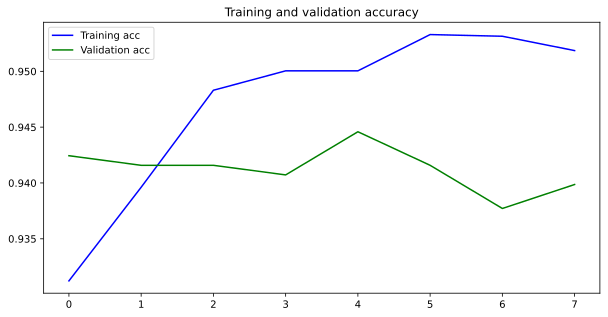

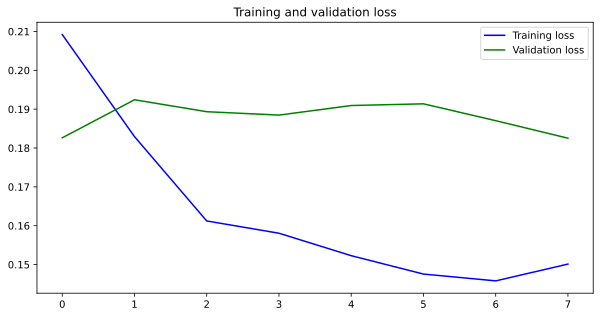

In [45]:
plot_history(history)

## Этап 4. Разморозка всех слоев базовой модели

In [46]:
base_model.trainable = True
LR=0.000001
# EPOCHS = 12

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [47]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - 416s 239ms/step - loss: 0.1626 - accuracy: 0.9448 - val_loss: 0.1811 - val_accuracy: 0.9459

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
1654/1654 [==============================] - 397s 240ms/step - loss: 0.1533 - accuracy: 0.9500 - val_loss: 0.1656 - val_accuracy: 0.9489

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 392s 237ms/step - loss: 0.1581 - accuracy: 0.9449 - val_loss: 0.1729 - val_accuracy: 0.9476

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 393s 237ms/step - loss: 0.1366 - accuracy: 0.9556 - val_loss: 0.1790 - val_accuracy: 0.9472

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
Epoch 5/8
1654/1654 [==============================] - 392s 237ms/step - loss: 0.1417 - accuracy: 0.9530 - val_loss: 0.1626 - val_accuracy: 0.9493


In [48]:
#model.save('../working/model_step4.hdf5') 
model.load_weights('best_model.hdf5') 

In [49]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 28s 95ms/step - loss: 0.1651 - accuracy: 0.9506
Accuracy: 95.06%


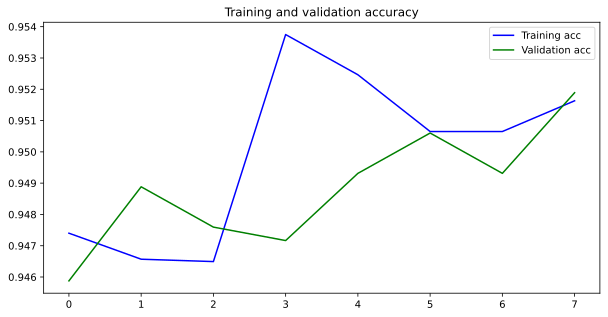

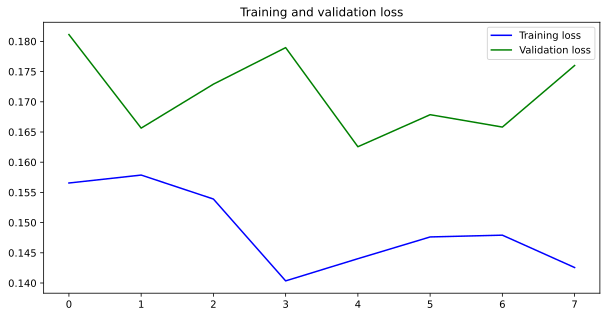

In [50]:
plot_history(history)

# Сабмит после fine-tuning

In [51]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [52]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 111s 130ms/step


In [53]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

## Этап 5. Дообучение модели на увеличенном размере изображения (Extra Fit)

In [63]:
EPOCHS               = 6
BATCH_SIZE           = 2 
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [64]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])

In [65]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [66]:
# загружаем базовую модель заново на новых размерах фото
base_model = efn.EfficientNetB5(weights='imagenet', 
                            include_top=False, 
                            input_shape = input_shape)

In [67]:
base_model.trainable = True

In [68]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])
model.load_weights('best_model.hdf5')

In [69]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/6
6616/6616 [==============================] - 2152s 322ms/step - loss: 1.2112 - accuracy: 0.6889 - val_loss: 0.1408 - val_accuracy: 0.9643

Epoch 00001: saving model to best_model.hdf5
Epoch 2/6
6616/6616 [==============================] - 2125s 321ms/step - loss: 0.7362 - accuracy: 0.8226 - val_loss: 0.1391 - val_accuracy: 0.9639

Epoch 00002: saving model to best_model.hdf5
Epoch 3/6
6616/6616 [==============================] - 2131s 322ms/step - loss: 0.6444 - accuracy: 0.8553 - val_loss: 0.1362 - val_accuracy: 0.9721

Epoch 00003: saving model to best_model.hdf5
Epoch 4/6
6616/6616 [==============================] - 2138s 323ms/step - loss: 0.6029 - accuracy: 0.8669 - val_loss: 0.1316 - val_accuracy: 0.9738

Epoch 00004: saving model to best_model.hdf5
Epoch 5/6
6616/6616 [==============================] - 2129s 322ms/step - loss: 0.6032 - accuracy: 0.8652 - val_loss: 0.1411 - val_accuracy: 0.9699

Epoch 00005: saving model to best_model.hdf5
Epoch 6/6
6616/6616 [=========

In [70]:
#!find /kaggle/working -name "*.hdf5" -type f -delete

In [71]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 68s 58ms/step - loss: 0.1439 - accuracy: 0.9729
Accuracy: 97.29%


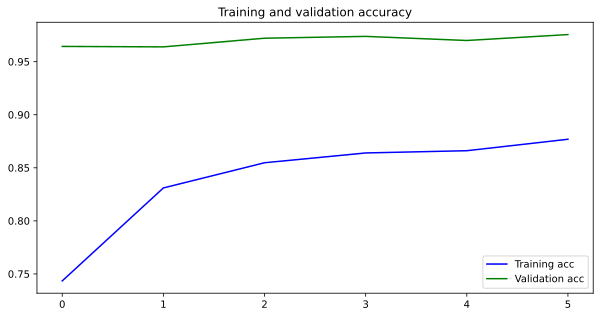

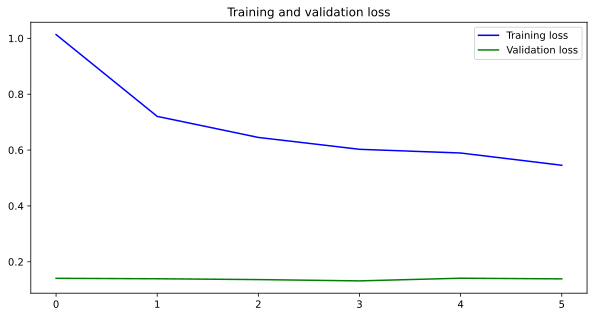

In [72]:
plot_history(history)

# Сабмит после изменения размера картинки

In [73]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

3338/3338 [==============================] - 191s 56ms/step


In [74]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

In [75]:
submission.to_csv('submission_IMG_SIZE.csv', index=False)

# Предсказание c TTA (Test time augmentation)

In [76]:
model.load_weights('best_model.hdf5')

In [77]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [78]:
test_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                      directory=DATA_PATH+'test/test_upload',
                                      x_col="Id",
                                      y_col=None,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode=None,
                                      shuffle=False)

Found 6675 validated image filenames.


In [79]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

3338/3338 [==============================] - 247s 74ms/step


In [80]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [81]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 68s 58ms/step - loss: 0.1439 - accuracy: 0.9729
Accuracy: 97.29%


In [82]:
submission.to_csv('submission_TTA.csv', index=False)

In [84]:
#Удалить папку с распакованными картинками
#import shutil
#shutil.rmtree(PATH)

# Результаты    
         
- score на kaggle = 0.97348 
- предварительные параметры для FT (EfficientNetB5, size=320, batch=8, Custom Head(128, Batch Normalization, use_bias=False, callback(MC_ES_LRS_T))
- score без TTA - 0,9729
- score c TTA - 0.97348


# Итоги             
                    
В проекте применены:     
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras        
- настройка LR    
- настройка параметров регуляризации полносвязного слоя нейронной сети
- применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations
- подобраны переменные (размер картинки, батч, количество эпох)
- добавлена Batch Normalization в архитектуре “головы” модели
- SOTA архитектура сетей -EfficientNetB5
- добавлена TTA (Test Time Augmentation)
                  

               